In [3]:
import csv
import os, ssl
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from textblob import TextBlob
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import leastsq

plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'medium'

Load CSV Data

In [4]:
from langdetect.lang_detect_exception import LangDetectException
def csv_to_list(filename):
    csv_data = []
    with open(filename) as csvfile:
        csv_reader = csv.reader(csvfile)
        csv_header = next(csv_reader)
        for row in csv_reader:
            csv_data.append(row)

    return csv_header, csv_data

tweets_csv = "COVID-19-Tweets-samples.csv"
tweets_header, tweets_data = csv_to_list(tweets_csv)

print(tweets_header)
print(tweets_data[0])

['Tweet_time', 'Tweet_id', 'Tweet_content', 'UserId', 'UserLocation', 'FollowerCount', 'RetweetTime']
['Sat Feb 29 09:48:39 +0000 2020', "'1233690537116545025", 'RT @spectatorindex: BREAKING: First case of coronavirus in Monaco', "'377470176", 'Conectica', '171', '964']


English Tweet_content Column Extraction

    Note tweets_text_en has not been sorted yet...

In [5]:
content_id = tweets_header.index("Tweet_content")
tweets_data_en = []
tweets_text_en = []
for row in tweets_data:    
    try:
        lang = detect(row[content_id])
    except LangDetectException:
        pass
        # print("No language features in text: "+ row[content_id])
    else:  
        if lang == "en":
            tweets_data_en.append(row)
            tweets_text_en.append(row[content_id])

print(len(tweets_text_en))
print(tweets_text_en[:5])



44884
['RT @spectatorindex: BREAKING: First case of coronavirus in Monaco', 'RT @RepBobbyRush: In 2012, I wore a hoodie on the House Floor to make a statement about the deadly consequences of racial profiling. On Wed…', 'RT @_IIlIIIIl: In 2017, China built a laboratory to study the Corona and Ebola virus in Wuhan, and US biosafety experts warned that the vir…', 'RT @drluebbers: what people say. what people do. #corona https://t.co/3yCQYLCn3f', 'RT @ReneusMeister: Social distancing explained for wrestling fans. https://t.co/Idtg9cE8G5']


Sentiment Analysis Using TextBlob

In [6]:
tweets_sentiment = []
for id,tweet in enumerate(tweets_text_en):
    tweets_id = tweets_data_en[id][tweets_header.index("Tweet_id")]
    
    blob = TextBlob(tweet)
    tweets_polarity = blob.sentiment.polarity
    tweets_subjectivity = blob.sentiment.subjectivity
    
    tweets_sentiment.append((tweets_id, tweets_polarity, tweets_subjectivity))

# sort by Tweet_id (i.e., the time posted)
tweets_sentiment = sorted(tweets_sentiment, key=lambda x:x[0])
print(tweets_sentiment[:5])

[("'1219753933968592897", 0.25, 0.3333333333333333), ("'1219757239436808192", 0.0, 0.5), ("'1219777055778230272", 0.325, 0.6666666666666666), ("'1219789360725483520", 0.09659090909090909, 0.284469696969697), ("'1219811361477275650", 0.0, 0.0)]


Sentiment Polarity Distribution 1 

    x-axis: sentiment polarity
    y-axis: probablity density function
    

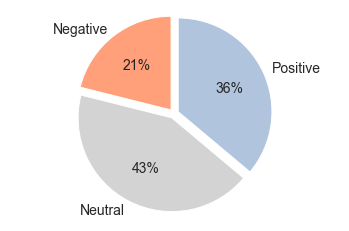

In [9]:
pol = [tweets_sentiment[i][1] for i in range(0, len(tweets_sentiment))]
pol = np.array(pol)

labels = ['Negative','Neutral','Positive']
sizes = [len(pol[pol<0]), len(pol[pol==0]), len(pol[pol>0])]
colors = ['lightsalmon', 'lightgrey', 'lightsteelblue']
explodes = [0.05, 0.05, 0.05]

patches, l_text, p_text = plt.pie(sizes, colors=colors, explode=explodes, labels=labels, autopct="%2.0f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")
plt.savefig("figures/polarity_dist_pie.eps",
            bbox_inches = 'tight')
plt.show()

Sentiment Polarity Distribution 2 

    x-axis: the polarity scores of tweets
    y-axis: density
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

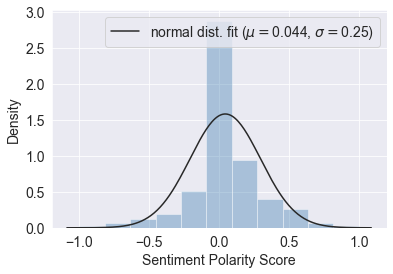

In [10]:
pol = [tweets_sentiment[i][1] for i in range(0, len(tweets_sentiment))]
# pol = np.array(pol)

sns.set_style('darkgrid')
sns.distplot(pol, norm_hist=True, rug=False, kde=False, bins=11, fit=norm,
             hist_kws={'color':'steelblue','label':'hist'})
(mu, sigma) = norm.fit(pol)

plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.xlabel('Sentiment Polarity Score')
plt.ylabel('Density')

plt.savefig("figures/polarity_dist_hist.eps",
            bbox_inches = 'tight')
plt.show()

Sentiment Subjectivity Distribution

    x-axis: the subjectivity scores of tweets
    y-axis: density
    
    This experiment has some issues... 

In [38]:
# sub = np.array([tweets_sentiment[i][2] for i in range(0, len(tweets_sentiment))])
# sub = sub[sub>0]
# sub = sub[sub<1]
# 
# sns.set_style('darkgrid')
# sns.distplot(sub, norm_hist=True, rug=False, kde=False, bins=11, fit=norm,
#              hist_kws={'color':'steelblue','label':'hist'})
# (mu, sigma) = norm.fit(sub)
# 
# plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
# plt.xlabel('Tweet Subjectivity Score')
# plt.ylabel('Density')
# 
# plt.savefig("/figures/subjectivity_dist_hist.eps",
#             bbox_inches = 'tight')
# plt.show()

Sequential Sentiment Analysis: Polarity

    x-axis: tweets in posting sequence
    y-axis: the polarity scores of tweets
    
    Note that to-do-tasks.txt mentions how to extend this experiment to temporal sentiment analysis

/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


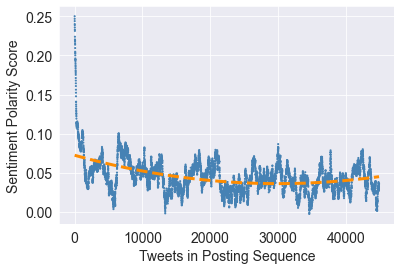

In [11]:
sentiments = {'seq': [i for i in range(1, len(tweets_sentiment) + 1)],
             'pol': [tweets_sentiment[i][1] for i in range(0, len(tweets_sentiment))]}

df = pd.DataFrame(sentiments)
df.head()

window = 500
# Simple moving average (SMA)
# pol = df.pol.rolling(window=window).mean()
# Exponential moving average (EMA)
pol = df.pol.ewm(span=window, adjust=False).mean()

x = df.seq[::5]
y = pol[::5]
plt.scatter(x, y, marker='.', s=5, c='', edgecolors='steelblue')

n = 2
# Using SMA -> move the first several nans
# parameter = np.polyfit(x[5:], y[5:], n)
# Using EMA -> no nans
parameter = np.polyfit(x, y, n)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
# plt.legend(["poly. fit ", f])

plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("Sentiment Polarity Score")
plt.savefig("figures/polarity_seq.eps",
            bbox_inches = 'tight')
plt.show()

Sequential Sentiment Analysis: Subjectivity

    x-axis: tweets in posting sequence
    y-axis: the subjectivity scores of tweets

/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


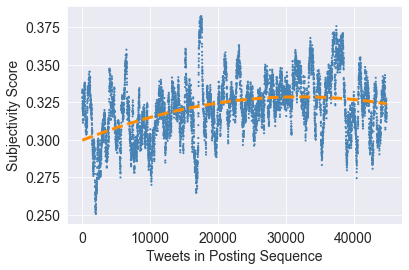

In [12]:
sentiments = {'seq': [i for i in range(1, len(tweets_sentiment) + 1)],
             'pol': [tweets_sentiment[i][2] for i in range(0, len(tweets_sentiment))]}

df = pd.DataFrame(sentiments)
df.head()

window = 500
# Simple moving average (SMA)
# pol = df.pol.rolling(window=window).mean()
# Exponential moving average (EMA)
pol = df.pol.ewm(span=window, adjust=False).mean()

x = df.seq[::5]
y = pol[::5]
plt.scatter(x, y, marker='.', s=5, c='', edgecolors='steelblue')

n = 2
# Using SMA -> move the first several nans
# parameter = np.polyfit(x[5:], y[5:], n)
# Using EMA -> no nans
parameter = np.polyfit(x, y, n)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
# plt.legend(["poly. fit ", f])

plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("Subjectivity Score")
plt.savefig("figures/subjectivity_seq.eps",
            bbox_inches = 'tight')
plt.show()

Save tweets_text_en for LIWC Software

In [46]:
with open("tweets_text_en.csv", "w") as f: 
    csv_write = csv.writer(f)
    for tweet in tweets_text_en:
        csv_write.writerow([tweet]) 

Load LIWC Results

In [16]:
liwc_csv = "tweets_text_en_liwc.csv"
liwc_categories, liwc_results = csv_to_list(liwc_csv)

print(liwc_categories)
print(liwc_results[0])

['Text', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'QMark', 'Exclam']
['RT @spectatorindex: BREAKING: First case of coronavirus in Monaco', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


LIWC Sentimental Lexicon Statistics

    - As a make up with the previous experiments
    - For sequential data, results are not differentiable
    

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '4.35', '4.17', '0.00', '0.00']
['0.00', '0.00', '4.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/mashazhou/PycharmProjects/COVID-19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


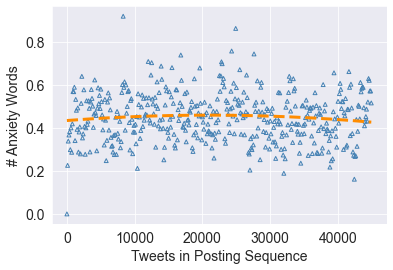

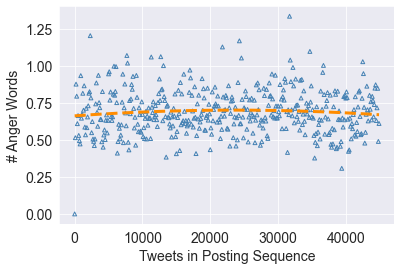

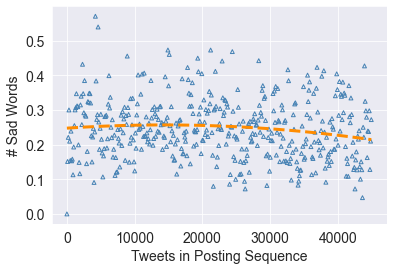

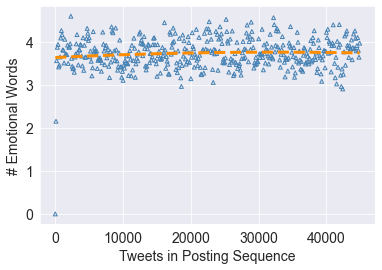

In [17]:
# the number of positive words
col = liwc_categories.index('posemo')
tweets_psemo_num = [liwc_results[i][col] for i in range(len(liwc_results))]
print(tweets_psemo_num[:10])

# the number of negative words
col = liwc_categories.index('negemo')
tweets_negemo_num = [liwc_results[i][col] for i in range(len(liwc_results))]
print(tweets_negemo_num[:10])

# the number of anxiety words
col = liwc_categories.index('anx')
tweets_anx_num = [liwc_results[i][col] for i in range(len(liwc_results))]
print(tweets_anx_num[:10])

# the number of anger words
col = liwc_categories.index('anger')
tweets_anger_num = [liwc_results[i][col] for i in range(len(liwc_results))]
print(tweets_anger_num[:10])

# the number of sad words
col = liwc_categories.index('sad')
tweets_sad_num = [liwc_results[i][col] for i in range(len(liwc_results))]
print(tweets_sad_num[:10])

# --------------
# figure plotting
sentiments = {'seq': [i for i in range(1, len(liwc_results) + 1)],
              'posemo': tweets_psemo_num,
              'negemo': tweets_negemo_num,
              'anx': tweets_anx_num,
              'anger': tweets_anger_num,
              'sad': tweets_sad_num}

df = pd.DataFrame(sentiments)
df.head()

window = 200
posemo = df.posemo.ewm(span=window, adjust=False).mean()
negemo = df.negemo.ewm(span=window, adjust=False).mean()
anx = df.anx.ewm(span=window, adjust=False).mean()
anger = df.anger.ewm(span=window, adjust=False).mean()
sad = df.sad.ewm(span=window, adjust=False).mean()

x = df.seq[::100]

# plt.figure(1)
# y = posemo[::100]
# plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
# parameter = np.polyfit(x, y, 2)
# f = np.poly1d(parameter) 
# plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
# plt.xlabel("Tweets in Posting Sequence")
# plt.ylabel("# Positive Words")
# plt.savefig("/Users/mashazhou/PycharmProjects/COVID-19/figures/emotions_pos_sequence.eps",
#             bbox_inches = 'tight')
# plt.show()


# plt.figure(2)
# y = negemo[::100]
# plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
# parameter = np.polyfit(x, y, 2)
# f = np.poly1d(parameter) 
# plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
# plt.xlabel("Tweets in Posting Sequence")
# plt.ylabel("# Negative Words")
# plt.savefig("/Users/mashazhou/PycharmProjects/COVID-19/figures/emotions_neg_seq.eps",
#             bbox_inches = 'tight')
# plt.show()

plt.figure(3)
y = anx[::100]
plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
parameter = np.polyfit(x, y, 2)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("# Anxiety Words")
plt.savefig("figures/anxiety_seq.eps",
            bbox_inches = 'tight')
plt.show()

plt.figure(4)
y = anger[::100]
plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
parameter = np.polyfit(x, y, 2)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("# Anger Words")
plt.savefig("figures/anger_seq.eps",
            bbox_inches = 'tight')
plt.show()


plt.figure(5)
y = sad[::100]
plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
parameter = np.polyfit(x, y, 2)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("# Sad Words")
plt.savefig("figures/sad_seq.eps",
            bbox_inches = 'tight')
plt.show()

plt.figure(6)
y = posemo[::100] + negemo[::100]
plt.scatter(x, y, marker='^', s=15, c='', edgecolors='steelblue')
parameter = np.polyfit(x, y, 2)
f = np.poly1d(parameter) 
plt.plot(x, f(x), linestyle='--', color='darkorange', linewidth=3)
plt.xlabel("Tweets in Posting Sequence")
plt.ylabel("# Emotional Words")
plt.savefig("figures/emotions_seq.eps",
            bbox_inches = 'tight')
plt.show()